In [8]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
import warnings

ModuleNotFoundError: No module named 'numpy'

In [4]:
df = pd.read_csv("data_date.csv")

NameError: name 'pd' is not defined

In [5]:
df.sample(5)

NameError: name 'df' is not defined

In [6]:
df.columns

NameError: name 'df' is not defined

In [5]:
df.shape

(10962, 4)

In [6]:
df.isnull().sum()

Date         0
Country      0
Status       0
AQI Value    0
dtype: int64

# Plot the distribution of AQI Values:

In [9]:
sns.histplot(data=df, x='AQI Value', bins=50, kde=True)
plt.title('Distribution of AQI Values')
plt.show()

NameError: name 'sns' is not defined

# Visualize AQI Values by Status:

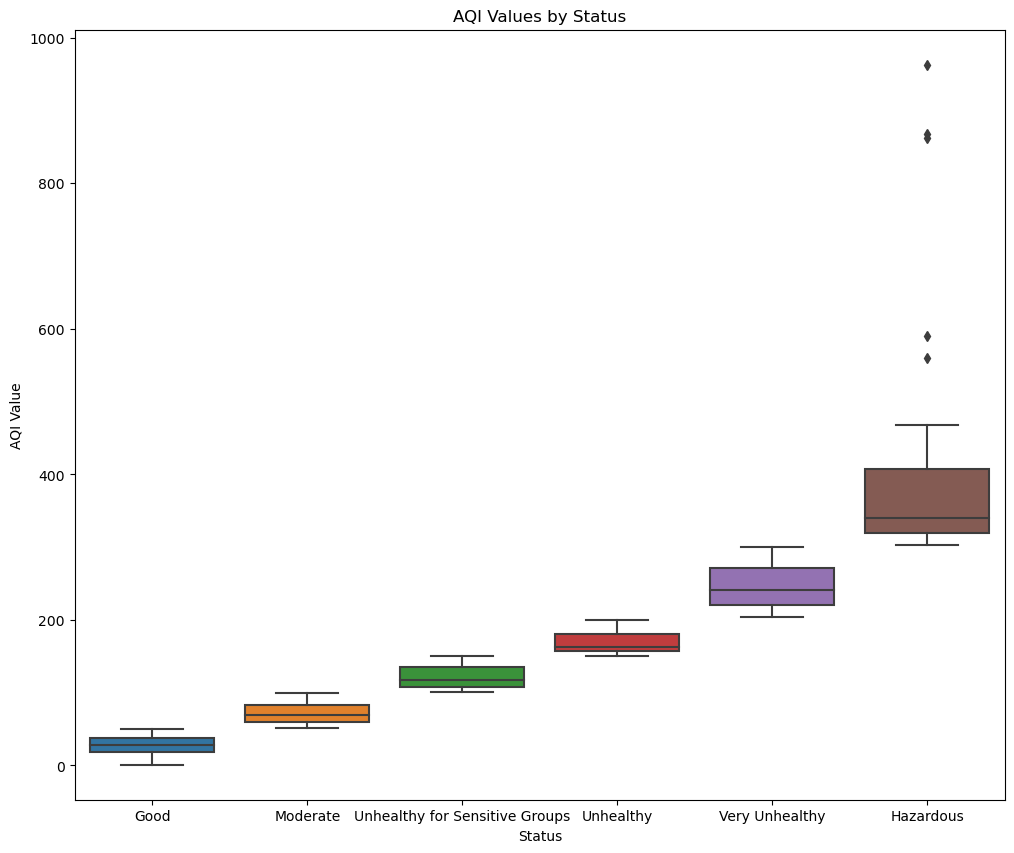

In [8]:
plt.figure(figsize=(12,10))
sns.boxplot(data=df, x='Status', y='AQI Value')
plt.title('AQI Values by Status')
plt.show()

# Visualize the average AQI Value for each country:

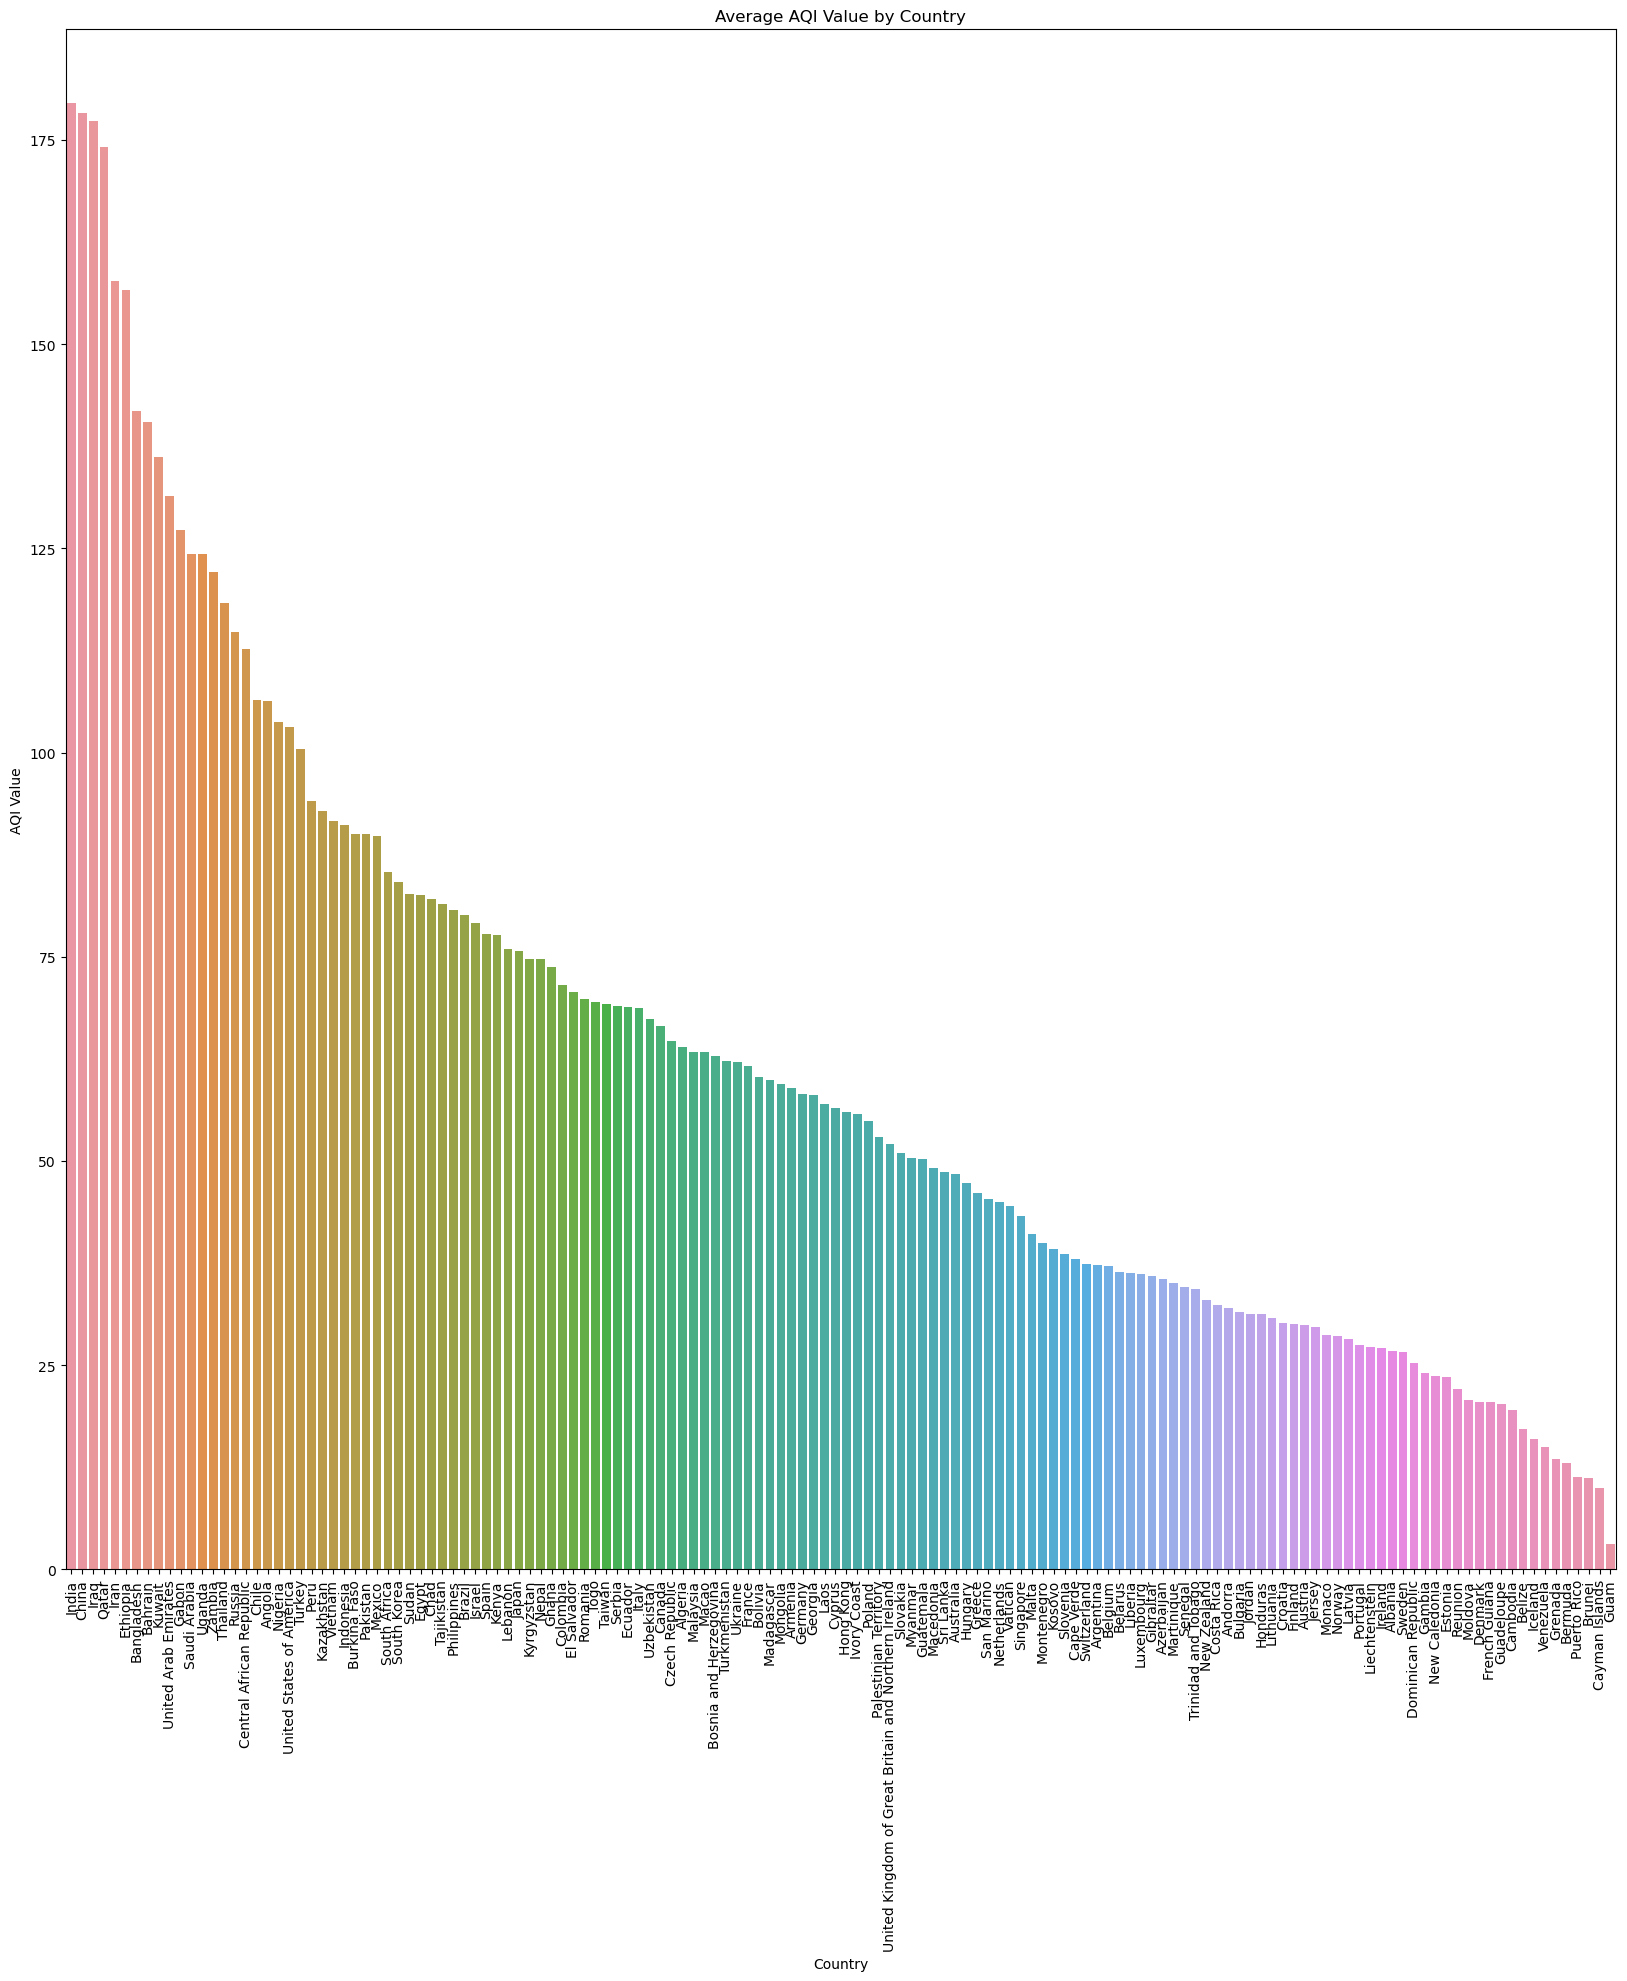

In [9]:
country_mean_aqi = df.groupby('Country')['AQI Value'].mean().reset_index()
country_mean_aqi = country_mean_aqi.sort_values(by='AQI Value', ascending=False)

plt.figure(figsize=(20, 20))
sns.barplot(data=country_mean_aqi, x='Country', y='AQI Value')
plt.xticks(rotation=90)
plt.title('Average AQI Value by Country')
plt.show()

# Preprocess the dataset for prophet:

In [10]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Group the data by date and take the mean AQI Value
global_aqi = df.groupby('Date')['AQI Value'].mean().reset_index()

# Rename columns for prophet
global_aqi.columns = ['ds', 'y']

## Create and fit the model:

In [11]:
m = Prophet()
m.fit(global_aqi)

17:46:03 - cmdstanpy - INFO - Chain [1] start processing
17:46:03 - cmdstanpy - INFO - Chain [1] done processing


# Make future predictions:

In [12]:
future = m.make_future_dataframe(periods=365)  # Make predictions for the next 365 days
forecast = m.predict(future)

# Plot the predictions:

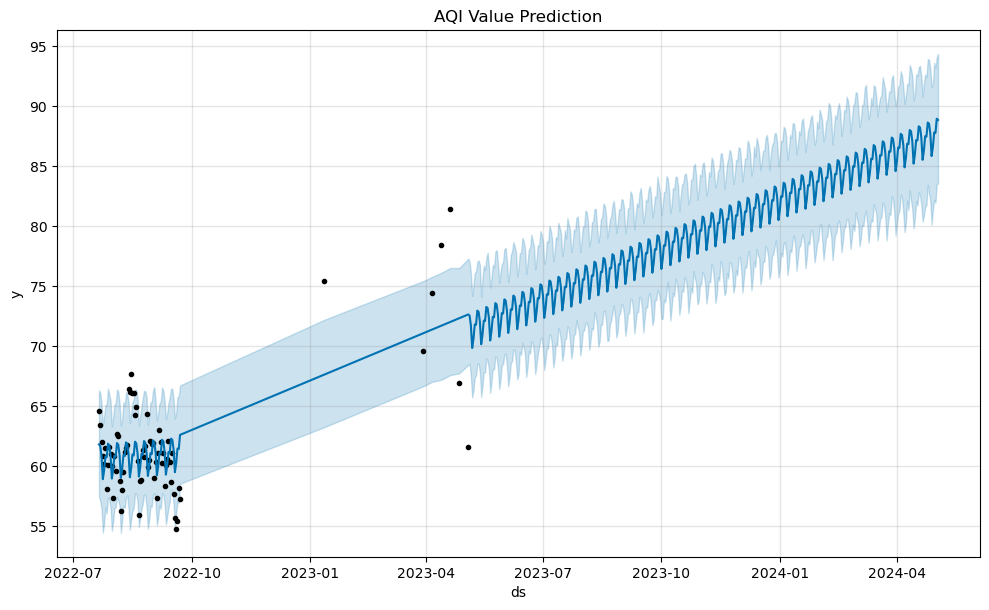

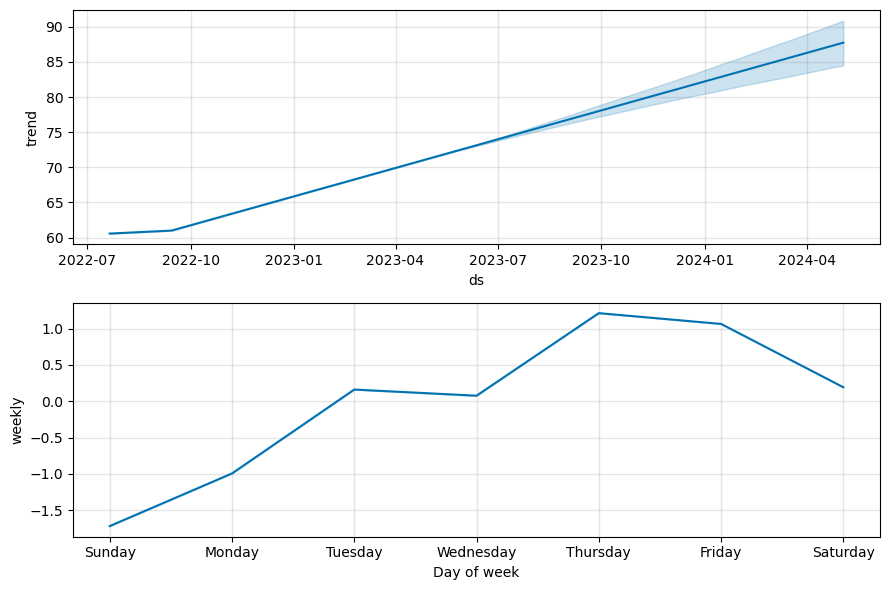

In [13]:
fig = m.plot(forecast)
plt.title('AQI Value Prediction')
plt.show()

# If you want to see the components of the forecast (trend, yearly seasonality, etc.)
fig2 = m.plot_components(forecast)
plt.show()

# Histogram of all columns in df

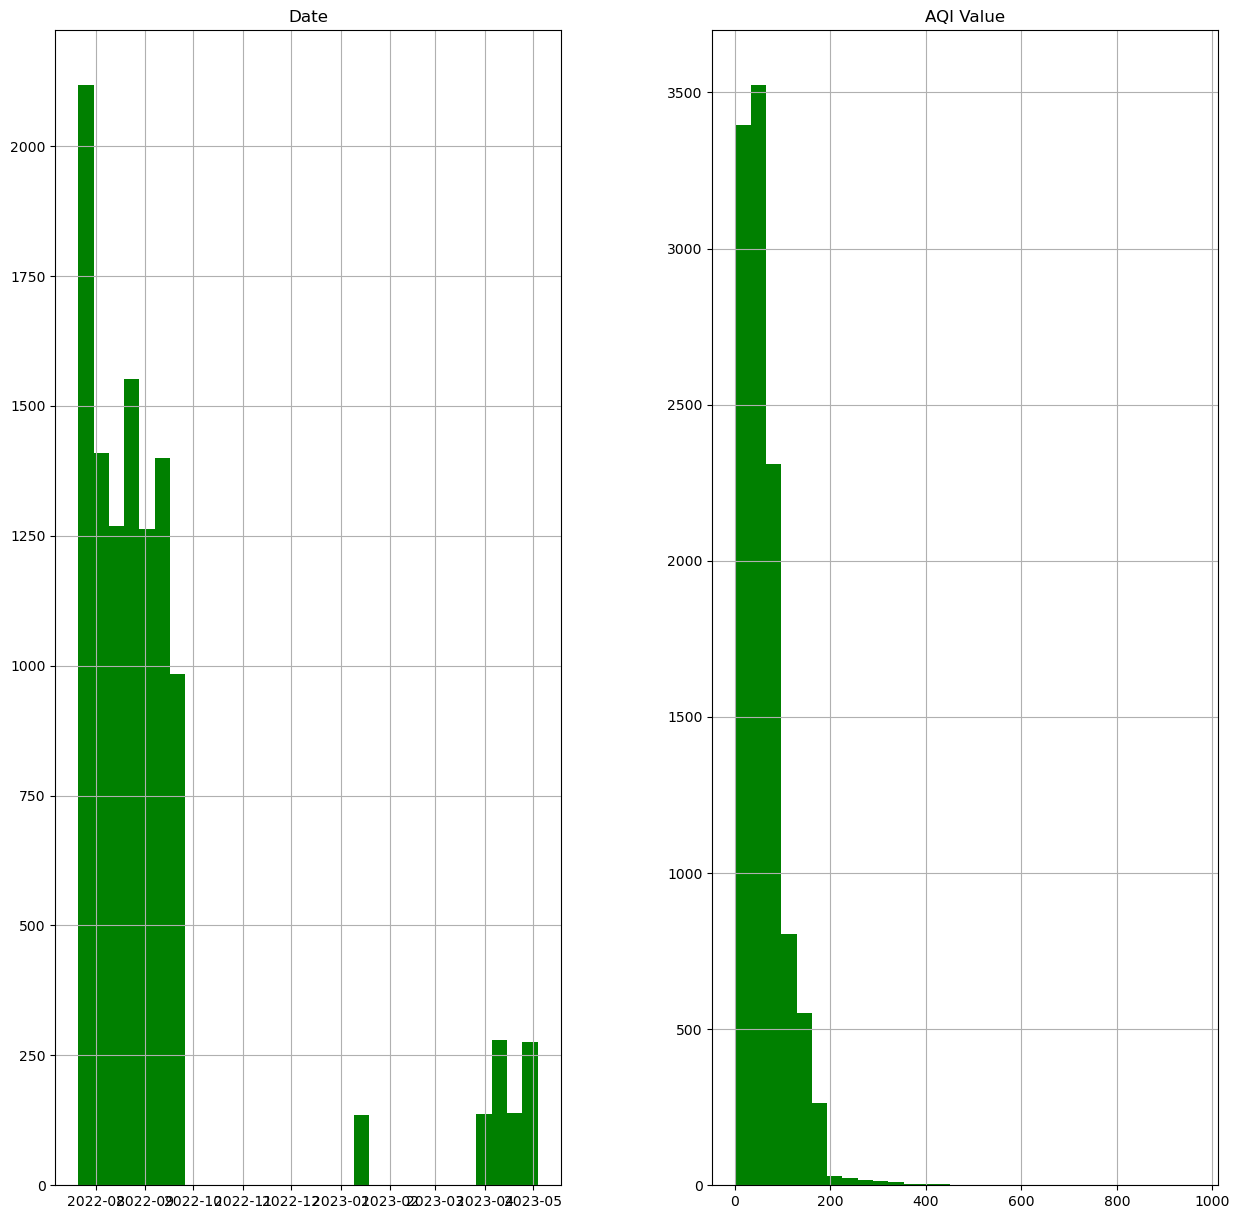

In [14]:
df.hist(bins=30,figsize=(15,15),color='g')
plt.show()

# fitting the ARIMA model:

ADF Statistic: -5.266248
p-value: 0.000006


D:\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


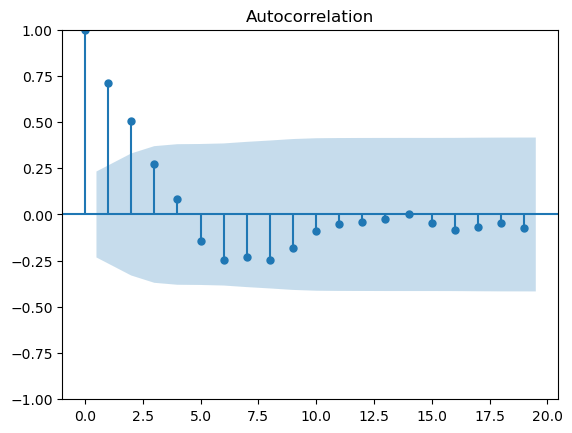

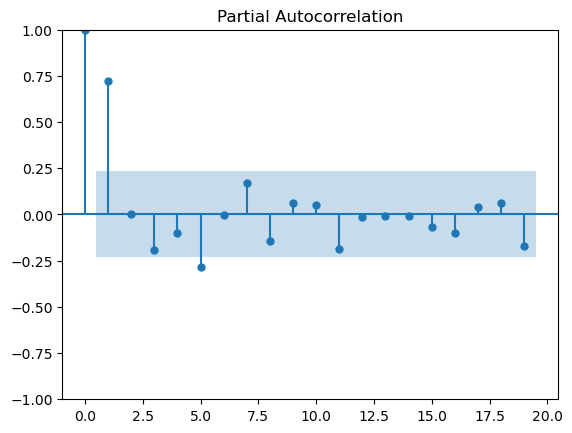

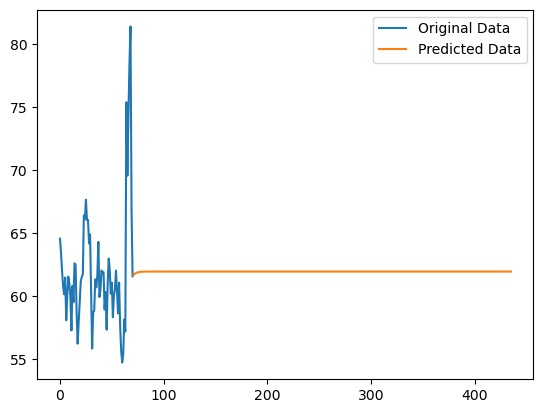

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Make the time series stationary (if needed) by differencing
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return pd.Series(diff)

# Check if the time series is stationary using the Augmented Dickey-Fuller test
result = adfuller(global_aqi['y'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# If the p-value is greater than 0.05, you may need to difference the data
if result[1] > 0.05:
    global_aqi['y'] = difference(global_aqi['y'])

# Determine the ARIMA parameters (p, d, q) using ACF and PACF plots
plot_acf(global_aqi['y'])
plot_pacf(global_aqi['y'])
plt.show()

# Set the parameters based on the ACF and PACF plots
p = 1
d = 0
q = 1

# Fit the ARIMA model
model = ARIMA(global_aqi['y'], order=(p, d, q))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(global_aqi), end=len(global_aqi)+364, dynamic=False)

# Plot the predictions
plt.plot(global_aqi['y'], label='Original Data')
plt.plot(predictions, label='Predicted Data')
plt.legend()
plt.show()

# SARIMA:

D:\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
D:\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


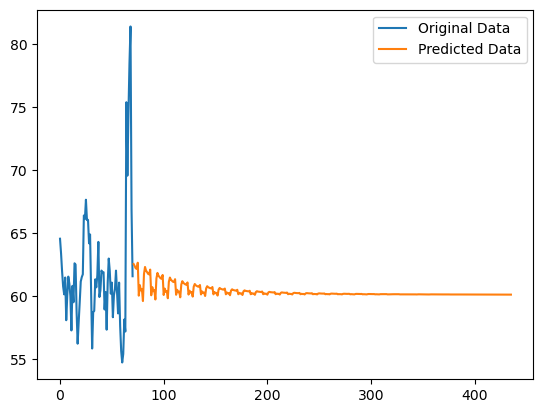

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the SARIMA parameters (p, d, q, P, D, Q, s)
p, d, q = 1, 0, 1
P, D, Q, s = 1, 0, 1, 12  # Assuming yearly seasonality

# Fit the SARIMA model
model = SARIMAX(global_aqi['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(global_aqi), end=len(global_aqi)+364, dynamic=False)

# Plot the predictions
plt.plot(global_aqi['y'], label='Original Data')
plt.plot(predictions, label='Predicted Data')
plt.legend()
plt.show()

# Split your data into training and testing sets:

In [17]:
train_size = int(len(global_aqi) * 0.8)
train = global_aqi.iloc[:train_size]
test = global_aqi.iloc[train_size:]

# Calculate the errors for ARIMA:

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Fit the ARIMA model on the training set
model = ARIMA(train['y'], order=(p, d, q))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate the errors
mae = mean_absolute_error(test['y'], predictions)
mse = mean_squared_error(test['y'], predictions)
rmse = np.sqrt(mse)

print('ARIMA Model:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

ARIMA Model:
MAE: 7.278770034639546
MSE: 87.85275843582964
RMSE: 9.37298023233964


# Calculate the errors for SARIMA:

In [19]:
# Fit the SARIMA model on the training set
model = SARIMAX(train['y'], order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)

# Calculate the errors
mae = mean_absolute_error(test['y'], predictions)
mse = mean_squared_error(test['y'], predictions)
rmse = np.sqrt(mse)

print('SARIMA Model:')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

SARIMA Model:
MAE: 7.455410726224901
MSE: 95.59459241215924
RMSE: 9.77724871383352
